In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd /content/drive/MyDrive/RML/HW4

/content/drive/MyDrive/RML/HW4


In [11]:
pwd

'/content/drive/MyDrive/RML/HW4'

# Explainability

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import ConcatDataset, DataLoader, TensorDataset, Dataset

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task 1

#### Please find the assciated text in the attached PDF

## Task 2

### Get the data

In [3]:
# Download CIFAR-10 training and testing datasets, then prepare corresponding dataloaders (batch size = 100)
cifar_train = datasets.CIFAR10("../data", train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10("../data", train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:01<00:00, 96966234.22it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [4]:
batch_size=100

train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

### Load the pretrained model and train it

In [5]:
# Download and load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the last layer to match the number of classes in the CIFAR-10 dataset
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

# Move the model to the device
resnet18 = resnet18.to(device)

# Verify if the model was loaded correctly
#print(resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 30.9MB/s]


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=1e-3, momentum=0.9)
n_epochs = 40

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

# Train the model
for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times
    running_loss = 0.0
    total_batches = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update running loss and batch count
        running_loss += loss.item()
        total_batches += 1

    avg_loss = running_loss / total_batches
    print(f'Epoch {epoch+1}/{n_epochs}, Average Training Loss: {avg_loss}')

    # Step the learning rate scheduler
    scheduler.step(avg_loss)

In [ ]:
# Set the model to evaluation mode
resnet18.eval()

# Initialize the variables for correct predictions and total number of predictions
correct = 0
total = 0

# No need to track gradients for validation, saves memory and computations
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


In [ ]:
# Save the trained model
torch.save(resnet18.state_dict(), 'resnet18_cifar10.pth')

# Load the model for future use
(model weights are attached)

In [15]:
## This was trained on collab, so please check the paths

# resnet18.load_state_dict(torch.load('resnet18_cifar10.pth'))

resnet18.load_state_dict(torch.load('resnet18_cifar10.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

### Helper functions

In [16]:
# Calculate the mean and std for CIFAR-10 dataset
cifar_mean = cifar_train.data.mean(axis=(0,1,2))/255  # Mean for RGB Channels
cifar_std = cifar_train.data.std(axis=(0,1,2))/255  # Std for RGB Channels

print("CIFAR-10 Mean: ", cifar_mean)
print("CIFAR-10 Standard Deviation: ", cifar_std)

CIFAR-10 Mean:  [0.49139968 0.48215841 0.44653091]
CIFAR-10 Standard Deviation:  [0.24703223 0.24348513 0.26158784]


In [17]:
## Taken from Assignment 1
class Normalize(nn.Module):
    def __init__(self):
        super(Normalize, self).__init__()
        self.mean = torch.from_numpy(cifar_mean)
        self.std = torch.from_numpy(cifar_std)

    def forward(self, x):
        return (x/255.0 - self.mean.type_as(x)[None, None, None, :]) / self.std.type_as(x)[None, None, None, :]

# Initialize the normalization layer
normalize = Normalize()

### Extract images

In [18]:
seed = 4

In [19]:
def get_random_images(dataset, seed):
    # Set the seed for the random number generator
    np.random.seed(seed)

    # Choose 5 random indices from the dataset
    random_indices = np.random.choice(len(dataset.data), size=5, replace=False)

    # Get the images and class indices of the chosen images
    images_and_classes = [(dataset.data[idx], dataset.targets[idx]) for idx in random_indices]

    return images_and_classes

In [20]:
cifar_images = get_random_images(cifar_train, seed)

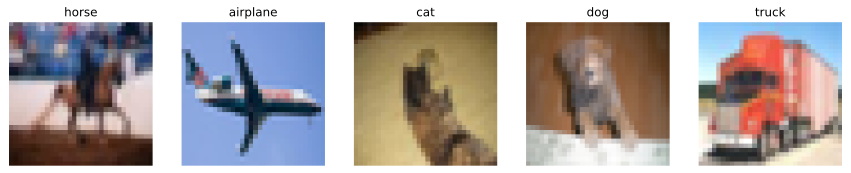

In [21]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (img, class_idx) in enumerate(cifar_images):
    axes[i].imshow(np.transpose(img, (0,1,2)))
    axes[i].set_title(classes[class_idx])
    axes[i].axis('off')
plt.show()

### Define SmoothGrad and compute the saliency maps

In [22]:
class SmoothGrad:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def generate_smoothgrad(self, input_image, target_class, std_dev, num_samples=50, weighted=True):
        input_image = input_image.detach().clone().requires_grad_(True)
        mean = 0
        sigma = std_dev * (torch.max(input_image) - torch.min(input_image)).item()
        grad_list = []
        for i in range(num_samples):
            if std_dev != 0:  # Add noise if std_dev is not 0
                noise = torch.normal(mean, sigma, size=input_image.size()).to(input_image.device)
                noisy_image = input_image + noise
            else:  # Otherwise, use the original image
                noisy_image = input_image
            output = self.model(noisy_image)
            self.model.zero_grad()
            # Create a one-hot encoded tensor of the target class
            target = torch.zeros_like(output)
            target[0][target_class] = 1
            output.backward(target)

            # Calculate gradients and cap extreme values
            grad = input_image.grad.cpu().data.numpy()
            percentile = np.percentile(grad, 99)
            grad[grad > percentile] = percentile
            grad_list.append(grad ** 2)  ## Absolute values of gradient

        # Compute the saliency map by taking the mean
        saliency_map = np.mean(np.array(grad_list), axis=0)

        if weighted:
          # Multiply saliency map with input image and normalize
          saliency_map = saliency_map * input_image.cpu().detach().numpy()
          saliency_map -= saliency_map.min()
          saliency_map /= saliency_map.max()
          saliency_map = np.uint8(saliency_map * 255)
        else:
          # Normalize the saliency map and convert it to an 8-bit integer
          saliency_map -= saliency_map.min()
          saliency_map /= saliency_map.max()
          saliency_map = np.uint8(saliency_map * 255)

        return saliency_map


saliency = SmoothGrad(resnet18)

In [25]:
def compute_saliency_map(saliency, cifar_images, noise_level):
    # Define the CIFAR-10 classes
    classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    fig, axes = plt.subplots(len(cifar_images), len(noise_level) + 1, figsize=(15, 3 * len(cifar_images)))

    for i, data in enumerate(cifar_images):
        img, class_idx = data
        # image_tensor = torch.tensor(img).unsqueeze(0).float().cuda()
        image_tensor = torch.tensor(img).unsqueeze(0).float()

        normed_image = normalize(image_tensor)

        if image_tensor.shape != (1, 3, 32, 32):
            image_tensor = image_tensor.permute(0, 3, 1, 2)

        # if normed_image.shape != (1, 3, 32, 32):
        #     normed_image = normed_image.permute(0, 3, 1, 2)

        # Plot the original image
        axes[i][0].imshow(np.transpose(img, (0,1,2)))
        axes[i][0].set_title('Original Image')
        axes[i][0].axis('off')

        for j, nl in enumerate(noise_level):
            #print(f"noise level: {nl}")
            saliency_map = saliency.generate_smoothgrad(image_tensor, class_idx, std_dev=nl)
            #print(type(saliency_map))
            #print(saliency_map.shape)
            saliency_map_reshaped = saliency_map.transpose((2, 3, 1, 0))
            saliency_map_gray = np.mean(saliency_map_reshaped, axis=2)

            axes[i][j+1].imshow(saliency_map_gray, cmap='gray')  # Shift the column index by 1
            axes[i][j+1].set_title(f'Noise Level: {int(nl*100)}%')

            axes[i][j+1].axis('off')

    plt.tight_layout()

    # Save the figure as a PNG file
    plt.savefig('saliency_maps.png')

    plt.show()


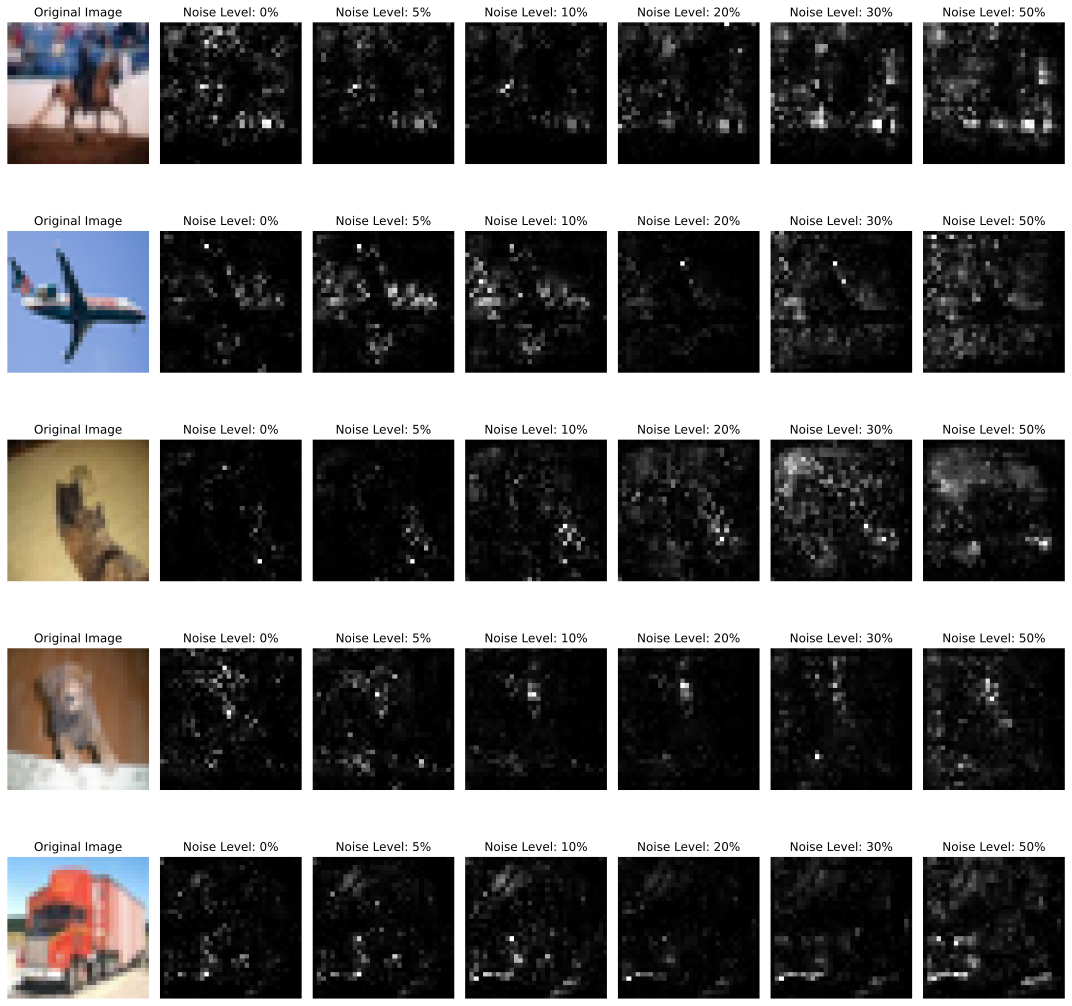

In [26]:
noise_level = [0, 0.05, 0.1, 0.2, 0.3, 0.5]
compute_saliency_map(saliency, cifar_images, noise_level)

#### Please find the assciated text in the attached PDF